In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2

import time
from collections import namedtuple
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Delete this block of code if you are not using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and Augment Data

In [4]:
class CityScapesData(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        data = np.load(##Directory of your cityScapes.npz)
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0']
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2']
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4']
            self.labels = data['arr_5']
            
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
            labels = self.transform(labels)
        return sample, labels

In [5]:
train_data = CityScapesData(trn_val_tst=0, transform=transforms.ToTensor()) 
valid_data = CityScapesData(trn_val_tst=1, transform=transforms.ToTensor()) 
test_data = CityScapesData(trn_val_tst=2, transform=transforms.ToTensor()) 

In [6]:
# Check length of all datasets
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1000
Number of validation examples: 250
Number of testing examples: 250


In [7]:
# Define dataloader
batch_size = 25
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)

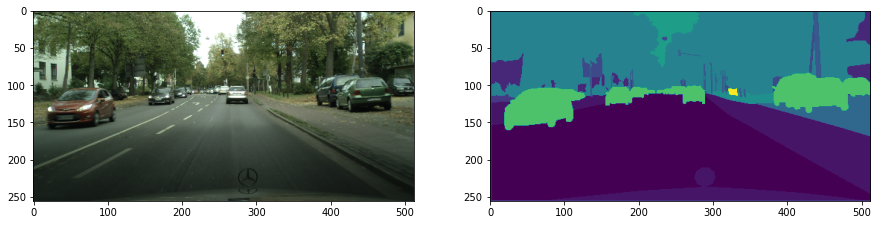

In [8]:
# Visualize data
images, labels = next(iter(train_loader))
plt.figure(figsize=(15,30))

plt.subplot(1,2,1)
plt.imshow(images[10].numpy().transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(labels[10].numpy().transpose(1,2,0).squeeze())

# Define Model

In [9]:
# Pyramid Pooling Module
# The neck of the PSPNet semantic segmentation algorithm
# This piece of code is referenced and modified from: https://github.com/hszhao/semseg

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.layers = []
        
        for bin in bins:
            self.layers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        # Make the modules iterable like Python list
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        
        for layer in self.layers:
            # Upsample each feature before appending them into "out" 
            out.append(F.interpolate(layer(x), x_size[2:], mode='bilinear', align_corners=True))
            
        # Concatenate every eleemnt in "out" over the channel (dimension 1) 
        return torch.cat(out, dim=1)

In [10]:
# The full PSPNet semantic segmentation algorithm
# This piece of code is referenced and modified from: https://github.com/hszhao/semseg
# EfficientNet is used here, instead of ResNet in the original literature

class PSPNet(nn.Module):
    def __init__(self, bins=(1, 2, 3, 6), dropout=0.1, classes=19, pretrained=True):
        super(PSPNet, self).__init__()

        # EfficientNet
        self.backbone = models.efficientnet_b3(pretrained=pretrained, progress=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Remove the classifier in Efficient Net 
        self.backbone = self.backbone.features

        # Change the structure of Efficient Net to change the final feature map size to 1/8 of the input
        for n,m in self.backbone[4][0].named_modules():
            if n == "block.1.0":
                m.stride = (1, 1)
                break
        
        for n,m in self.backbone[6][0].named_modules():
            if n == "block.1.0":
                m.stride = (1, 1)
                break

        # PPM
        fea_dim = 1536
        self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
        fea_dim *= 2
        
        # Classifier
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )

    def forward(self, x):
        x_size = x.size()
        h = x_size[2]
        w = x_size[3]
        x = self.backbone(x)
        # x shape = BatchSize-1536-H/8-W/8
        x = self.ppm(x)
        # x shape = BatchSize-3072-H/8-W/8
        x = self.cls(x)
        # x shape = BatchSize-19-H/8-W/8
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
        # x shape = BatchSize-19-256-512
        return x

# Define Utility Functions




In [11]:
# Function to calculate IoU for each classes and accuracy
def IoU(output, target, classes, ignore_index=19):
    
    # Shape of output and target should be the same
    assert output.shape == target.squeeze().shape
    # Type of output and target should be numpy array
    assert type(output) == type(np.array([1]))
    assert type(target) == type(np.array([1]))
    
    # Reshape to 1D array
    output = output.reshape(output.size).copy()
    target = target.reshape(target.size)
    output[np.where(target == ignore_index)] = ignore_index
    intersection = output[np.where(output == target)]
    areaIntersect, _ = np.histogram(intersection, bins=np.arange(classes))
    areaOutput, _ = np.histogram(output, bins=np.arange(classes))
    areaTarget, _ = np.histogram(target, bins=np.arange(classes))
    areaUnion = areaOutput + areaTarget - areaIntersect
    IoU = areaIntersect/ (areaUnion + 1e-10) # Add 1e-10 at the denominator to prevent divide by zero
    mean_IoU = sum(IoU)/np.count_nonzero(IoU)
    accuracy = sum(areaIntersect) / sum(areaOutput)
    return (mean_IoU, accuracy)

In [12]:
def poly_learning_rate(base_lr, epoch, max_epoch, power=0.9):
    lr = base_lr * (1 - float(epoch) / max_epoch) ** power
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Define training process

In [13]:
def train_model(model, device, loader, loss_fn, optimizer, loss_logger):
    
    # Set network in train mode
    model.train()
    
    # To store sum of loss per epoch
    loss_logger_tmp = 0.0
    
    for batch_id, (data, label) in enumerate(loader):
        # Forward Pass
        outputs = model(data.float().to(device))
        
        # Calculate Loss
        loss = loss_fn(outputs, label.squeeze().long().to(device))
        
        # Zero all gradient from the previous iteration to prevent gradient accumulation
        optimizer.zero_grad()
        
        # Back propagation to obtain new gradient 
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Log every training loss
        loss_logger_tmp += loss.item()
    
    # Calculate average loss per epoch
    loss_logger_tmp /= len(loader)
    
    # Log training loss
    loss_logger.append(loss_logger_tmp)
    
    return loss_logger

In [14]:
# For validation
def validate_model(model, device, loader, loss_logger):
    
    # Set network in evaluation mode
    model.eval()
    
    # To store sum of loss per epoch
    loss_logger_tmp = 0.0
    
    with torch.no_grad():
        for batch_id, (data, label) in enumerate(loader):
            # Forward Pass
            outputs = model(data.float().to(device))
            
            # Calculate Loss
            loss = loss_fn(outputs, label.squeeze().long().to(device))
            
            # Log every training loss
            loss_logger_tmp += loss.item()
        
        # Calculate average loss per epoch
        loss_logger_tmp /= len(loader)

        # Log training loss
        loss_logger.append(loss_logger_tmp)
    
    return loss_logger

In [15]:
# For testing
def test_model(model, device, loader, meanIoU_logger, accuracy_logger):
    
    # Set network in evaluation mode
    model.eval()
    
    meanIoU_tmp = 0.0
    accuracy_tmp = 0.0
    
    with torch.no_grad():
        for batch_id, (data, label) in enumerate(loader):
            # Forward Pass
            outputs = model(data.float().to(device))
            
            # Calculate mean_IoU and accuracy
            tmp1, tmp2 = IoU(outputs.argmax(1).cpu().numpy(), label.cpu().numpy(), 20)
            meanIoU_tmp += tmp1
            accuracy_tmp += tmp2
        
        # Calculate average mean_IoU and accuracy per epoch
        meanIoU_tmp /= len(loader)
        accuracy_tmp /= len(loader)
        
        # Log average mean_IoU and accuracy per epoch
        meanIoU_logger.append(meanIoU_tmp)
        accuracy_logger.append(accuracy_tmp)
    
    return meanIoU_logger, accuracy_logger

In [16]:
# Define Hyperparameters
learn  = 5e-4    # learning rate
nepoch = 50      # number of epoch
decay  = 1e-4    # weight decay

# Create Model
model = PSPNet().float().to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=learn, weight_decay=decay)

# Define loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=19)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

# Load Checkpoint

In [17]:
start_epoch    = 0
best_valid_acc = 0
start_from_checkpoint = True
save_dir = '/content/drive/MyDrive/ECE4179/Project/Models'
model_name = 'PSPNet_2'

#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded, starting from epoch: 35


In [19]:
# Initialize logger

training_loss_logger = []
validation_loss_logger = []

training_IoU_logger = []
validation_IoU_logger = []
test_IoU_logger = []


training_acc_logger = []
validation_acc_logger = []
test_acc_logger = []

if start_from_checkpoint == True:
  plotData = np.load('/content/drive/MyDrive/ECE4179/Project/plotData1.npz')
  training_loss_logger = plotData['arr_0'].tolist()
  validation_loss_logger = plotData['arr_1'].tolist()
  training_IoU_logger = plotData['arr_2'].tolist()
  validation_IoU_logger = plotData['arr_3'].tolist()
  test_IoU_logger = plotData['arr_4'].tolist()
  training_acc_logger = plotData['arr_5'].tolist()
  validation_acc_logger = plotData['arr_6'].tolist()
  test_acc_logger = plotData['arr_7'].tolist()

In [ ]:
for epoch in range(start_epoch,nepoch):

    start_time = time.time()

    # Train
    training_loss_logger = train_model(model, device, train_loader, loss_fn, optimizer, training_loss_logger)
    
    # Validate
    validation_loss_logger = validate_model(model, device, valid_loader, validation_loss_logger)
    
    # Test
    validation_IoU_logger, validation_acc_logger = test_model(model, device, valid_loader, validation_IoU_logger, validation_acc_logger)
    test_IoU_logger, test_acc_logger = test_model(model, device, test_loader, test_IoU_logger, test_acc_logger)

    # Scheduler update learning rate
    poly_learning_rate(learn, epoch, nepoch, power=0.9)
    
    if (validation_acc_logger[-1] > best_valid_acc):
        best_valid_acc = validation_acc_logger[-1]
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      model.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'valid_acc':             validation_acc_logger[-1],
        }, save_path)

    end_time = time.time()

    # Track the training process
    print(f'| Epoch: {epoch+1:02} | Train Loss: {training_loss_logger[-1]:.2f} | Val. Loss: {validation_loss_logger[-1]:.2f}')
    print(f'| Epoch: {epoch+1:02} | Val. Acc: {validation_acc_logger[-1]*100:05.2f}% | Test. Acc: {test_acc_logger[-1]*100:05.2f}% | Time Taken: {end_time - start_time}s')
    
print("Training Complete")

In [ ]:
#np.savez_compressed('plotData1.npz', training_loss_logger, validation_loss_logger, training_IoU_logger, validation_IoU_logger, test_IoU_logger, training_acc_logger, validation_acc_logger, test_acc_logger)

In [ ]:
#!mv plotData1.npz /content/drive/MyDrive

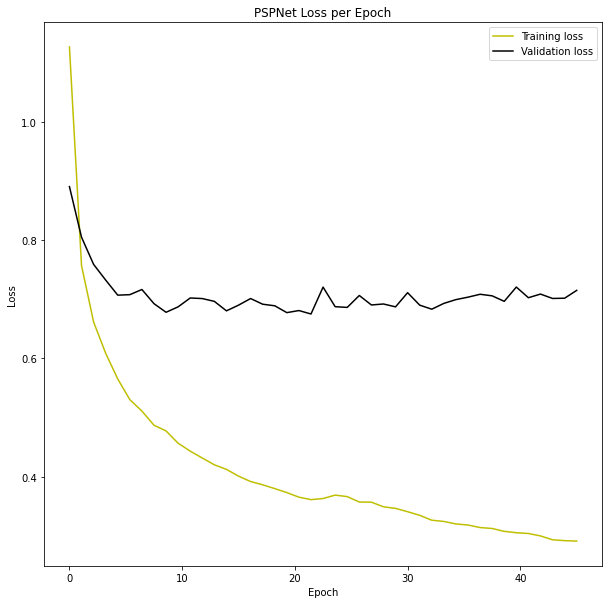

In [ ]:
# Visualize training loss and validation loss throughout the epochs
plt.figure(figsize = (10,10))
train_x = np.linspace(0, 45, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
val_x = np.linspace(0, 45, len(validation_loss_logger))
plt.plot(val_x, validation_loss_logger, c = "k")

plt.title("PSPNet Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])

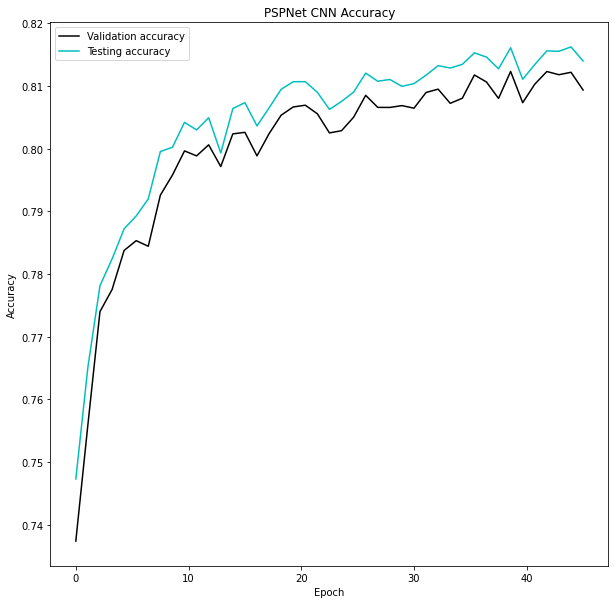

In [ ]:
# Visualize training accuracy, validation accuracy, and testing accuracy throughout the epochs
plt.figure(figsize = (10,10))

valid_x = np.linspace(0, 45, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

test_x = np.linspace(0, 45, len(test_acc_logger))
plt.plot(test_x, test_acc_logger, c = "c")

plt.title("PSPNet CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Validation accuracy", "Testing accuracy"])

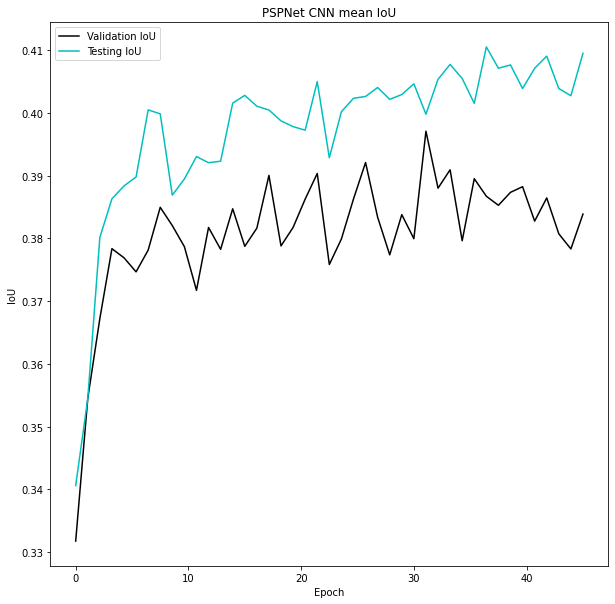

In [ ]:
# Visualize training IoU, validation IoU, and testing IoU throughout the epochs
plt.figure(figsize = (10,10))

valid_x = np.linspace(0, 45, len(validation_IoU_logger))
plt.plot(valid_x, validation_IoU_logger, c = "k")

test_x = np.linspace(0, 45, len(test_IoU_logger))
plt.plot(test_x, test_IoU_logger, c = "c")

plt.title("PSPNet CNN mean IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend(["Validation IoU", "Testing IoU"])

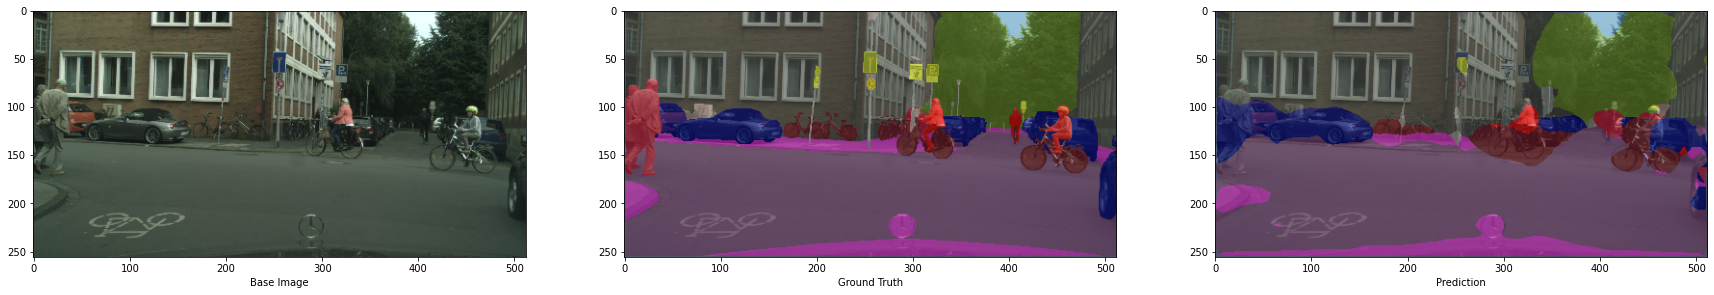

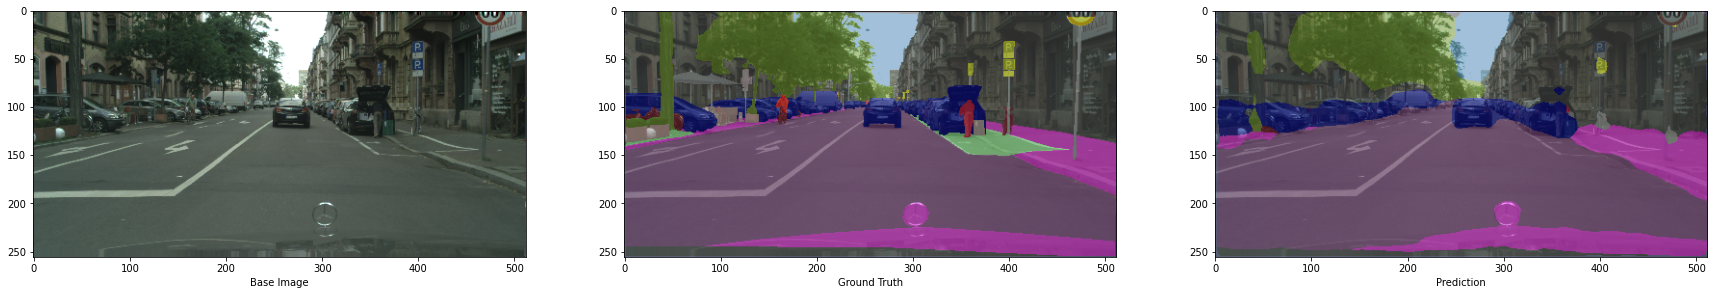

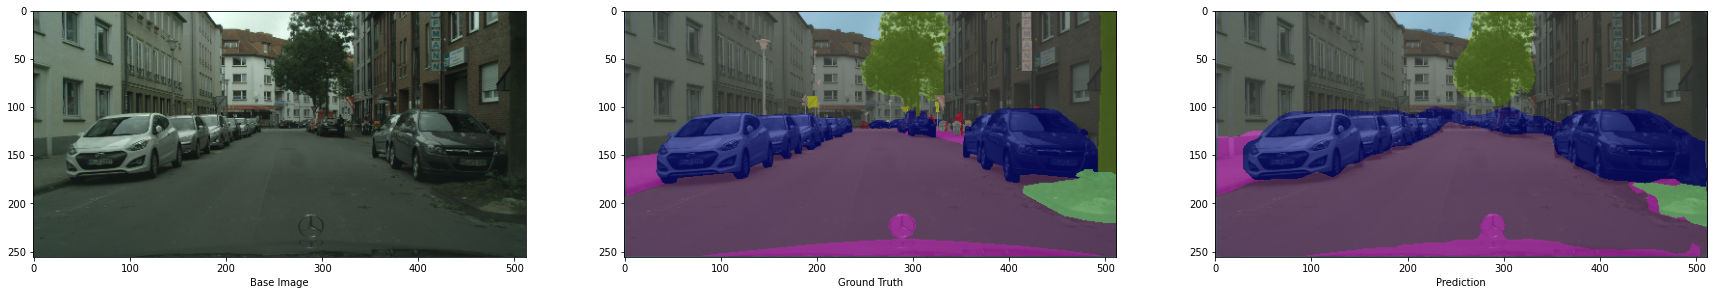

0.08667421340942383


In [20]:
color = [(128, 64,128),
         (244, 35,232),
         ( 70, 70, 70),
         (102,102,156),
         (190,153,153),
         (153,153,153),
         (250,170, 30),
         (220,220,  0),
         (107,142, 35),
         (152,251,152),
         ( 70,130,180),
         (220, 20, 60),
         (255,  0,  0),
         (  0,  0,142),
         (  0,  0, 70),
         (  0, 60,100),
         (  0, 80,100),
         (  0,  0,230),
         (119, 11, 32),
         (  0,  0,  0)
         ]

color = np.array(color)

# Compare base image, ground truths and outputs from model
data_compare_iter = iter(test_loader)

with torch.no_grad():
    for i in range(3):
        plt.figure(figsize=(30, 30))
        image, label = next(data_compare_iter)
        
        plt.subplot(1,3,1)
        plt.imshow(image[7].numpy().transpose(1, 2, 0))
        plt.xlabel("Base Image")
        
        plt.subplot(1,3,2)
        colorLabel = color[label[7].flatten().int().tolist()]
        colorLabel = np.array(colorLabel)
        colorLabel = colorLabel.reshape((256,512,3))
        showLabel = cv2.add(image[7].numpy().transpose(1, 2, 0)*0.5, colorLabel/255*0.5)
        plt.imshow(showLabel)
        plt.xlabel("Ground Truth")
        
        inference_start = time.time()
        output = model(image.float().to(device))
        pred = torch.argmax(output,dim=1)
        inference_end = time.time()
        inference = inference_end - inference_start

        plt.subplot(1,3,3)
        colorPred = color[pred[7].flatten().int().tolist()]
        colorPred = np.array(colorPred)
        colorPred = colorPred.reshape((256,512,3))
        showPred = cv2.add(image[7].numpy().transpose(1, 2, 0)*0.5, colorPred/255*0.5)
        plt.imshow(showPred)
        plt.xlabel("Prediction")
        plt.show()

print(inference)